In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import random
from scipy.stats import kstest,zscore
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess

In [69]:
df = pd.read_csv("C:\\Users\\şerefcanmemiş\\Downloads\\insurance.csv")

## 1 - Veriyi İnceleme

In [70]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


- **age:** yaş
- **sex:** cinsiyet
- **bmi:** vücut kitle indeksi 
- **children:** çocuk sayısı
- **smoker:** sigara içme durumu
- **region:** yaşadığı bölge
- **charges:** sigorta ücreti

In [71]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Her bir değişkenin kaç tane eşsiz değere sahip olduğu.

In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Sayısal sütunların istatistiksel özeti.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Her bir sütun için veri tipleri.

In [74]:
df.isna().sum().sum()

0

Veride NA değeri yani eksik gözlem olmadığını görüyoruz.

**Aykırı değerleri (Outlier) görmek için sayısal değişkenlerde kutu grafiği (boxplot) çizdiriyoruz.**

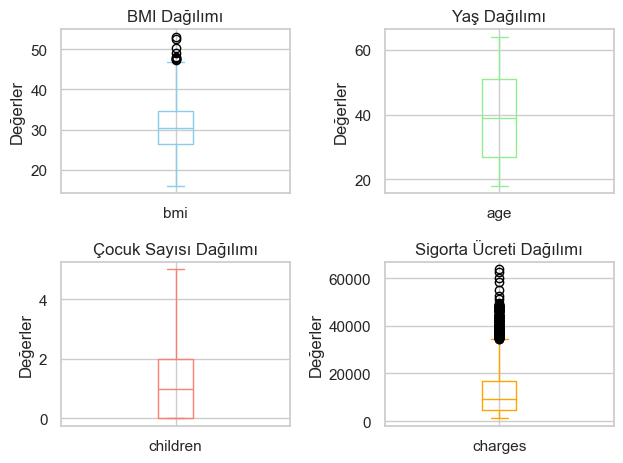

In [80]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2)

df['bmi'].plot(ax=axs[0, 0], kind='box', color='skyblue')
df['age'].plot(ax=axs[0, 1], kind='box', color='lightgreen')
df['children'].plot(ax=axs[1, 0], kind='box', color='salmon')
df['charges'].plot(ax=axs[1, 1], kind='box', color='orange')

axs[0, 0].set_title('BMI Dağılımı')
axs[0, 1].set_title('Yaş Dağılımı')
axs[1, 0].set_title('Çocuk Sayısı Dağılımı')
axs[1, 1].set_title('Sigorta Ücreti Dağılımı')

for ax in axs.flat:
    ax.set_ylabel('Değerler')

plt.tight_layout()
plt.show()

**Sigara içen ve sigara içmeyenlerin dağılımını pasta grafiği (pieplot) yardımı ile görüyoruz.**

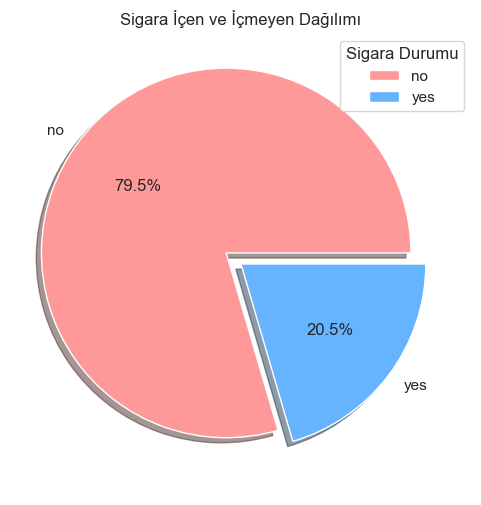

In [76]:
smoker_counts = df['smoker'].value_counts()
labels = smoker_counts.index
colors = ['#ff9999','#66b3ff']
plt.figure(figsize=(6,6))
plt.pie(smoker_counts, labels=labels, autopct='%1.1f%%', colors=colors, explode=(0.1, 0), shadow=True)
plt.title("Sigara İçen ve İçmeyen Dağılımı")
plt.legend(labels, title="Sigara Durumu")
plt.show()

**Sayısal değişkenlerin dağılımını incelemek için histplot çizelim.**

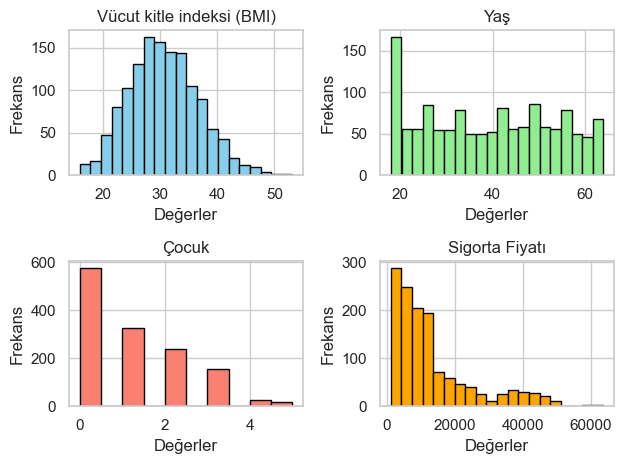

In [79]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2)

df['bmi'].plot(ax=axs[0, 0], kind='hist', color='skyblue', bins=20, edgecolor='black', title='Vücut kitle indeksi (BMI)')
df['age'].plot(ax=axs[0, 1], kind='hist', color='lightgreen', bins=20, edgecolor='black', title='Yaş')
df['children'].plot(ax=axs[1, 0], kind='hist', color='salmon', bins=10, edgecolor='black', title='Çocuk')
df['charges'].plot(ax=axs[1, 1], kind='hist', color='orange', bins=20, edgecolor='black', title='Sigorta Fiyatı')

for ax in axs.flat:
    ax.set_xlabel('Değerler')
    ax.set_ylabel('Frekans')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()
plt.show()

**Vücut kitle endeksi ve yaşın, sağlık sigorta parasını nasıl etkilediğine saçılım grafiği(scatterplot) yardımı ile inceleyelim.**

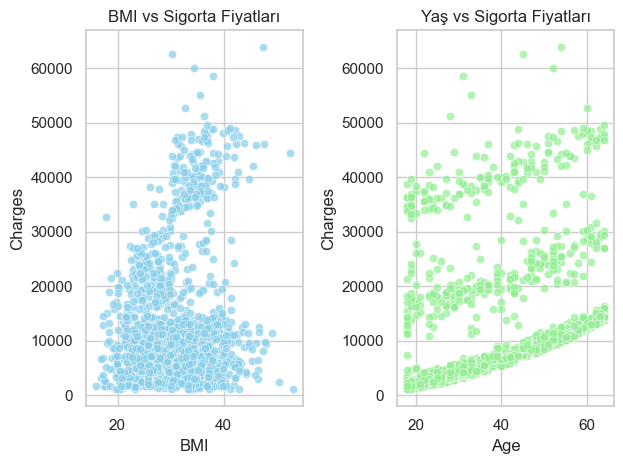

In [85]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 2)
sns.scatterplot(x='bmi', y='charges', data=df, ax=axs[0], color='skyblue', alpha=0.7)
sns.scatterplot(x='age', y='charges', data=df, ax=axs[1], color='lightgreen', alpha=0.7)

axs[0].set_title('BMI vs Sigorta Fiyatları')
axs[0].set_xlabel('BMI')
axs[0].set_ylabel('Charges')

axs[1].set_title('Yaş vs Sigorta Fiyatları')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Charges')

plt.tight_layout()
plt.show()

**Farklı bölgelere göre sağlık sigortası fiyatları nasıl değişiyor Sütun grafiği(Barplot) yardımı ile inceleyelim.**

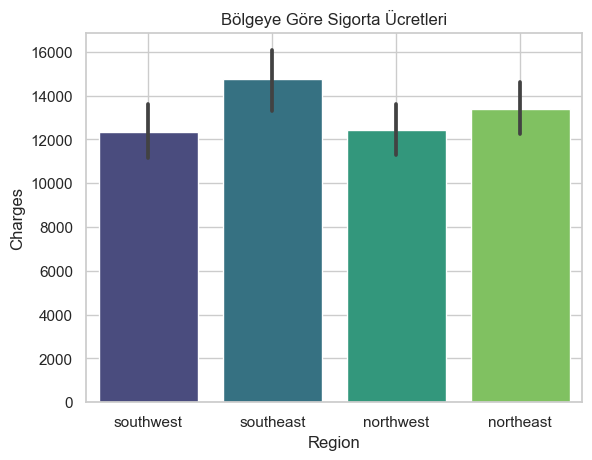

In [87]:
sns.set(style="whitegrid")
sns.barplot(x='region', y='charges', data=df, palette='viridis')

plt.title('Bölgeye Göre Sigorta Ücretleri')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.grid(True)
plt.show()

## 2- Özellik Mühendisliği (Feature Engineering)

**Kategorik olan sütunları modele ekleyebilmek için sayısal değerlere dönüştürüyoruz.**

In [14]:
for column in ['sex','smoker']:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


**Aynı şekilde dummy değişkenleri de dönüştürüyoruz**.    (Burada n-1 sutun oluşturmamızın sebebi regresyon modelinde çoklu doğrusal bağlantıyı engellemek.)

In [15]:
df = pd.get_dummies(df,columns=['region'],prefix='region',dtype=int,drop_first=True)
df.sample(5)

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
1069,54,0,31.90,1,0,10928.8490,0,1,0
651,53,0,39.60,1,0,10579.7110,0,1,0
247,24,1,35.86,0,0,1986.9334,0,1,0
15,19,1,24.60,1,0,1837.2370,0,0,1
365,49,0,30.78,1,0,9778.3472,0,0,0


## 3- Modelleme

## Lineer Regresyon

- Değişkenler arasındaki doğrusal ilişkiyi bulmak ve bağımlı değişkeni tahmin etmek için kullanılır.

In [16]:
X = df.drop('charges',axis = 1)
y = df['charges']
x_egitim, x_test, y_egitim, y_test = train_test_split(X,y,test_size = 0.2)

In [17]:
model = LinearRegression().fit(x_egitim,y_egitim)
pred = model.predict(x_test)
error = mean_squared_error(y_test,pred)
r2 = r2_score(y_test,pred)
mape = mean_absolute_percentage_error(y_test,pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(f'mean absolute percentage error (MAPE) değeri: {mape}')

R^2 değeri: 0.7481
mean squared error (MSE) değeri: 41153035.9847
mean absolute percentage error (MAPE) değeri: 0.4400347172374209


## Statsmodels ile Lineer Regresyon

In [26]:
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:40:17   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819    -12.086      0.000   -1.39e+04      -1e+04
age                256.8564     11.899     21.587      0.000     233.514     280.199
sex               -131.3144    332.945     -0.394      0.693    -784.470     521.842
bmi                339.1935     28.599     11.860      0.000     283.088     395.298
children           475.5005    137.804      3.451      0.001     205.163     745.838
smoker            2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
region_northwest  -352.9639    476.276     -0.741      0.459   -1287.298     581.370
region_southeast -1035.0220    478.692     -2.162      0.031   -1974.097     -95.947
region_southwest  -960.0510    477.933     -2.009      0.045   -1897.636     -22.466
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Lineer Regesyon için varsayım kontrolleri

#### 1- Doğrusallık Varsayımı

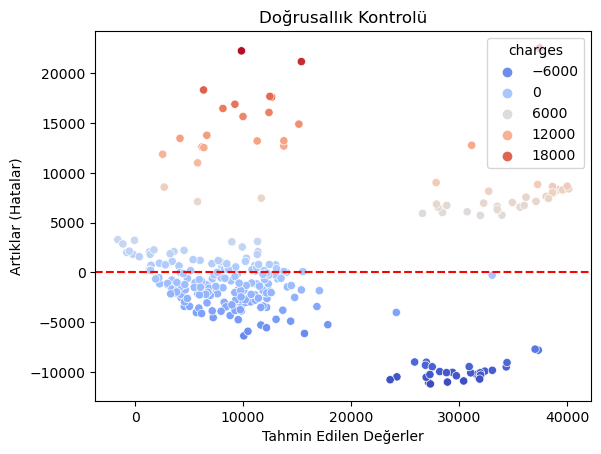

In [56]:
residuals = y_test - pred
sns.scatterplot(x=pred, y=residuals, palette="coolwarm",hue=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Tahmin Edilen Değerler")
plt.ylabel("Artıklar (Hatalar)")
plt.title("Doğrusallık Kontrolü")
plt.show()

#### 2- Degisen Varyans Varsayımı

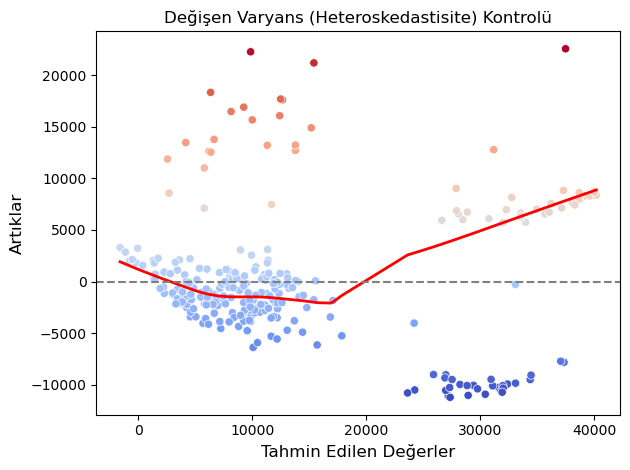

In [58]:
residuals = y_test - pred
sns.scatterplot(x=pred, y=residuals, hue=residuals,
                palette="coolwarm", legend=False)
lowess_line = lowess(residuals, pred)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='red', linewidth=2)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Tahmin Edilen Değerler", fontsize=12)
plt.ylabel("Artıklar", fontsize=12)
plt.title("Değişen Varyans (Heteroskedastisite) Kontrolü")
plt.tight_layout()
plt.show()

In [31]:
a, pval, b, c = het_breuschpagan(model.resid, model.model.exog)

if pval < 0.05:
    print("Heteroskedastisite var",pval)
else:
    print("Varyans sabit (homoskedastisite)",pval)

Heteroskedastisite var 1.4467175539179645e-22


Değişen Varyans varsayımı sağlanmıyor.

#### 3- Normallik Varsayımı

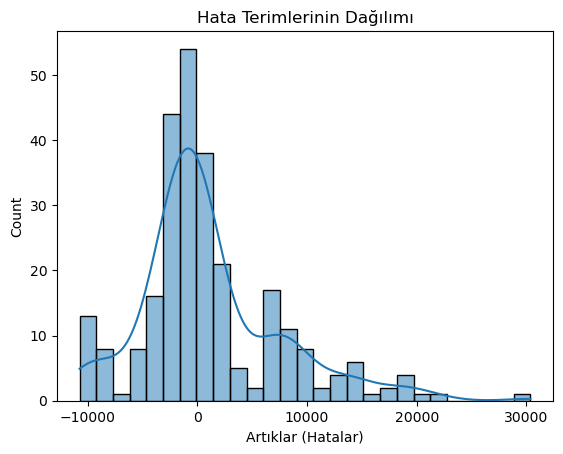

In [25]:
sns.histplot(y_test - pred, kde=True)
plt.xlabel("Artıklar (Hatalar)")
plt.title("Hata Terimlerinin Dağılımı")
plt.show()

In [38]:
zskoru = zscore(df['charges'])
df = df[zskoru.abs()<3]
k,p_value = kstest(y_test-pred,'norm')
if p_value < 0.05:
    print("Normal dagilmaz ",p_value)
else:
    print("Normal dagilir:",p_value)

Normal dagilmaz  9.221790381786407e-92


Aykırı değerleri çıkarmamıza rağmen p-value degeri 0.05'ten çok küçük geldi yani hatalar normal dağılmıyor.

#### 4- Otokorelasyon (Hataların bağımsızlığı)

In [27]:
dw_stat = durbin_watson(y_test - pred)
print(f"Durbin-Watson Test İstatistiği: {dw_stat:.4f}")

Durbin-Watson Test İstatistiği: 1.9966


Durbin-Watson test istatisiği 0-4 arasında değer alır 2'ye yakın olması burada otokorelasyon olmadığının göstergesidir.

#### 5- Çoklu Doğrusal Bağlantı

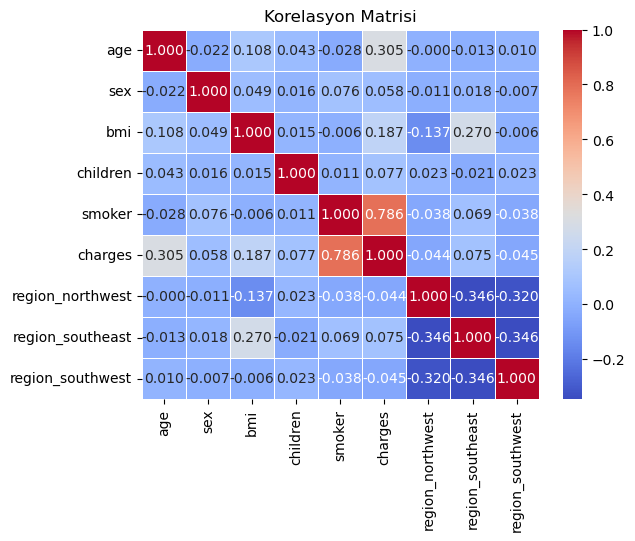

In [28]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

In [29]:
vif = pd.DataFrame(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest','region_southeast', 'region_southwest'])
vif['vif'] = [variance_inflation_factor(x_egitim.values,i) for i in range(len(x_egitim.columns))]
vif

,0,vif
0,age,7.868805
1,sex,2.028672
2,bmi,11.794040
3,children,1.822654
4,smoker,1.252265
5,region_northwest,1.999915
6,region_southeast,2.398302
7,region_southwest,2.037680


age ve bmi'ın vif değerleri yüksek geldi bunlar PCA veya çıkarma işlemi ile düzeltilebilir.

Aykırı değerler çıktıktan sonra **Lineer Regresyon** modelini tekrar kuruyoruz.

In [30]:
X = df.drop('charges',axis = 1)
y = df['charges']
x_egitim, x_test, y_egitim, y_test = train_test_split(X,y,test_size = 0.2)
print(x_egitim.shape)
print(y_egitim.shape)

(1064, 8)
(1064,)


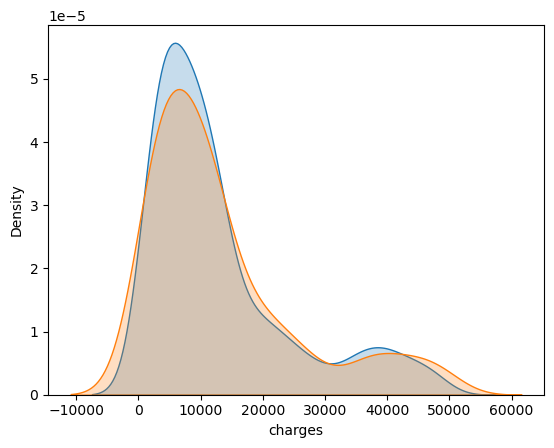

In [31]:
sns.kdeplot(y_egitim, label="Eğitim Seti", fill=True)
sns.kdeplot(y_test, label="Test Seti", fill=True)
plt.show()

Charges değişkeninin eğitim seti ile test seti dağılımları birbirlerine benzer olup olmadığını görmek için kdeplot çizdirdik.

**Fakat Burada Varsayımlardan sağlanmayanlar olduğu için Lineer Regresyon geçersiz bir modeldir.**

## Temel Bileşen Analizi (PCA)

- Verideki en fazla varyansı açıklayan değişkenleri bulur.
- Boyut indirgeme yaparak modeli basitleştirir.

In [51]:
cv = KFold(n_splits=5,shuffle=True,random_state=40)
pca = PCA()
x_egitim_scaled = pca.fit_transform(scale(x_egitim))
regression = LinearRegression()
mse = []
for i in range(1,x_egitim.shape[1]+1):
    score = -1*model_selection.cross_val_score(regression, x_egitim_scaled[:,:i], y_egitim, cv=cv,
                                           scoring="neg_mean_squared_error").mean()
    mse.append(score)

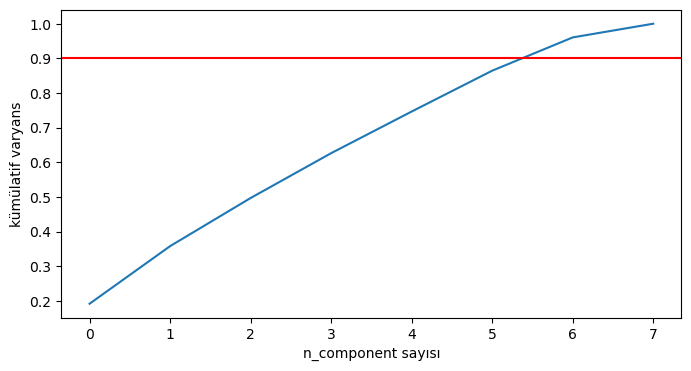

In [49]:
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.90, c='r')
plt.xlabel('n_component sayısı')
plt.ylabel('kümülatif varyans')
plt.show()

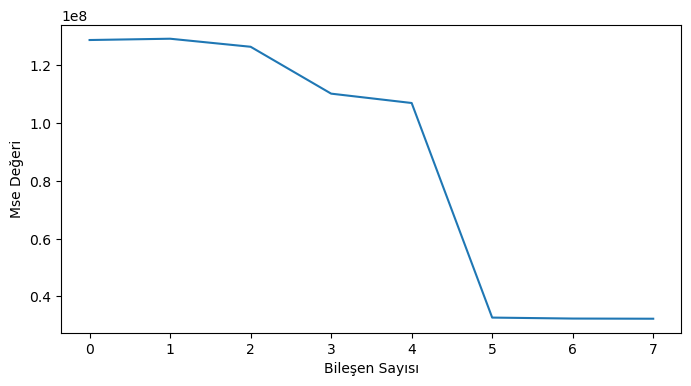

In [50]:
plt.figure(figsize=(8,4))
plt.plot(mse)
plt.xlabel('Bileşen Sayısı')
plt.ylabel('Mse Değeri')
plt.show()

In [81]:
print(f'6 componentın varyansı açıklama oranı: {sum(pca.explained_variance_ratio_[:6]):.4f}')

6 componentın varyansı açıklama oranı: 0.8644


Keskin düşüşlerin olduğu değişkenler veriyi iyi açıklayan değişkenlerdir.

In [85]:
pca = PCA(n_components=8)
x_egitim_scaled = pca.fit_transform(scale(x_egitim))
x_test_scaled = pca.transform(scale(x_test))
pcreg = model.fit(x_egitim_scaled,y_egitim)
pred = pcreg.predict(x_test_scaled)

error = mean_squared_error(y_test,pred)
r2 = r2_score(y_test,pred)
mape = mean_absolute_percentage_error(y_test,pred)
print(f'mean absolute percentage error (MAPE) değeri: {mape}')
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

mean absolute percentage error (MAPE) değeri: 0.44279642233986977
R^2 değeri: 0.7158
mean squared error (MSE) değeri: 42578348.6446


## Kısmi En Küçük Kareler Regresyonu (PLS)

- PCA'daki gibi boyut indirme yapar.
- Lineer Regresyon gibi tahminleme yapar.
- Bu ikisini bağımlı değişken ile olan ilişkiyi koruyarak yapar.

In [86]:
pls_model = PLSRegression()
def optimum_pls(x,y,ncomp):
    model = PLSRegression(n_components=ncomp)
    cv_step = cross_val_predict(model,x,y,cv=5)
    mse = mean_squared_error(y,cv_step)
    r2 = r2_score(y,cv_step)
    return (cv_step,mse,r2)

In [87]:
sonuc_df = pd.DataFrame(columns = ['ncomp','R^2','MSE'])
r2 = []
mse_list = []
ncomp = []
for i in np.arange(1,9):
    cv.step,mse,rsq= optimum_pls(x_egitim, y_egitim, i)
    r2.append(rsq)
    mse_list.append(mse)
    ncomp.append(i)
    
sonuc_df['ncomp'] = ncomp
sonuc_df['R^2'] = r2
sonuc_df['MSE'] = mse_list
sonuc_df

,ncomp,R^2,MSE
0,1,0.741326,3.452499e+07
1,2,0.758191,3.227403e+07
2,3,0.759164,3.214407e+07
3,4,0.758938,3.217432e+07
4,5,0.758983,3.216832e+07
5,6,0.758965,3.217072e+07
6,7,0.758967,3.217041e+07
7,8,0.758967,3.217038e+07


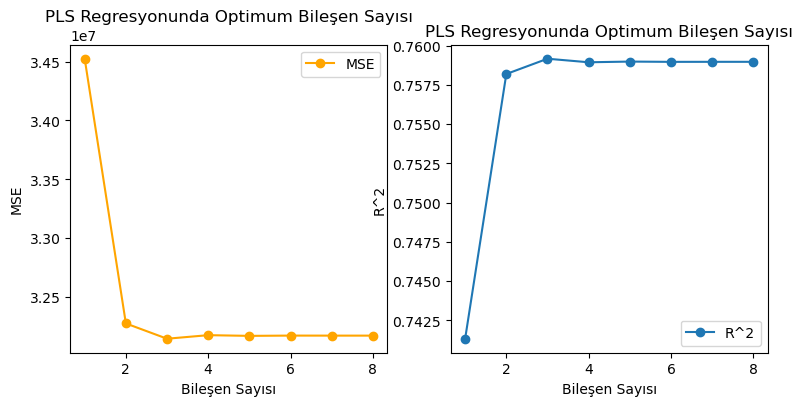

In [88]:
fig,axs = plt.subplots(1,2, figsize=(9,4))
axs[0].plot(range(1, 9), mse_list, marker='o', label='MSE',color='orange')
axs[0].set_xlabel("Bileşen Sayısı")
axs[0].set_ylabel("MSE")
axs[0].set_title("PLS Regresyonunda Optimum Bileşen Sayısı")
axs[0].legend()

axs[1].plot(range(1, 9), r2, marker='o', label='R^2')
axs[1].set_xlabel("Bileşen Sayısı")
axs[1].set_ylabel("R^2")
axs[1].set_title("PLS Regresyonunda Optimum Bileşen Sayısı")
axs[1].legend()
plt.show()

In [89]:
model2= PLSRegression(n_components=2).fit(x_egitim, y_egitim)
pred2= model2.predict(x_test)
error = mean_squared_error(y_test,pred2)
r2 = r2_score(y_test,pred2)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

R^2 değeri: 0.7138
mean squared error (MSE) değeri: 42871420.3322


Optimum n_components'ı 2 olarak buluyoruz.

## Ridge Regresyon

- Tüm değişkenleri modelde tutar ama katsayıları küçülterek modelin karmaşıklığını azaltır.
- Aşırı öğrenmeyi önlemeye yardımcı olur.

In [112]:
scaler = StandardScaler()
x_egitim_scaled = scaler.fit_transform(x_egitim)
x_test_scaled = scaler.transform(x_test)

In [113]:
alphas = np.array([0.001,0.01,0.1,0.2,0.5,1,1.1,2,3,4,4.5,5,10])
ridge_model = RidgeCV(alphas=alphas,cv=5).fit(x_egitim_scaled,y_egitim)
preds = ridge_model.predict(x_test_scaled)

error = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(f'optimum alpha değeri: {ridge_model.alpha_}')

R^2 değeri: 0.7939
mean squared error (MSE) değeri: 27221247.6713
optimum alpha değeri: 3.0


## Lasso Regresyon

- Gereksiz degişkenlerin katsayısını 0'a düşürerek değişken seçimi yapar.
- Bu sayede modelin aşırı öğrenmesini engeller.

In [114]:
lasso_model = LassoCV(cv=10,max_iter=500).fit(x_egitim_scaled,y_egitim)
preds = lasso_model.predict(x_test_scaled)
error = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)

print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(f'optimum alpha değeri: {lasso_model.alpha_:.4f}')

R^2 değeri: 0.7941
mean squared error (MSE) değeri: 27200663.4735
optimum alpha değeri: 31.9927


## K En Yakın Komşular Regresyonu (KNN)

- Yeni bir gözlemi tahmin ederken en yakın k komşunun ortalamasını baz alan bir modeldir.
- Ölçeklemek (Normalize) çok önemlidir.

In [115]:
knn_regression = KNeighborsRegressor()
params= {"n_neighbors":[2,3,5,5,6,7,8,9,10,15,20,30]}
KNN_Model = GridSearchCV(knn_regression,param_grid=params,cv=5).fit(x_egitim_scaled,y_egitim)
preds = KNN_Model.predict(x_test_scaled)

error = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(f'optimum n_neighbors değeri: {KNN_Model.best_params_}')

R^2 değeri: 0.8117
mean squared error (MSE) değeri: 24878247.8558
optimum n_neighbors değeri: {'n_neighbors': 5}


KNN scale etmeden kötü sonuç verdi scale edince modelin performansı arttı.

## Destek Vektör Makineleri (SVM)

- Sınıflar arasındaki boşluğu maksimize ederek veriyi en iyi ayıran düzlemi oluşturur.
- SVR'de belirli bir tolerans içinde en iyi tahmin çizgisini bulur.

In [116]:
model_svr = SVR(kernel='linear').fit(x_egitim,y_egitim)
y_pred = model_svr.predict(x_test)
error = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

R^2 değeri: -0.1088
mean squared error (MSE) değeri: 146471312.7744


In [117]:
scale = StandardScaler()
x_egitim_scaled = scale.fit_transform(x_egitim)
x_test_scaled = scale.fit_transform(x_test)

In [118]:
svr_params = {'C':np.arange(100,160,1),'epsilon':[0.1]}
GSCV_SVR_model = GridSearchCV(model_svr,svr_params,cv = 10)
model_GS = GSCV_SVR_model.fit(x_egitim_scaled,y_egitim)

opt_c = pd.Series(model_GS.best_params_)[0]
opt_e = pd.Series(model_GS.best_params_)[1]
model_optimum = SVR(kernel = "linear", C = opt_c, epsilon = opt_e).fit(x_egitim_scaled, y_egitim)

y_pred_optimum = model_optimum.predict(x_test_scaled)
error = mean_squared_error(y_test, y_pred_optimum)
r2 = r2_score(y_test, y_pred_optimum)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(f'optimum C değeri: {opt_c:.2f}')
print(f'optimum epsilon değeri: {opt_e:.2f}')

R^2 değeri: 0.6801
mean squared error (MSE) değeri: 42259724.7520
optimum C değeri: 159.00
optimum epsilon değeri: 0.10


## Yapay Sinir Ağları (ANN - MLP)

ANN, birbirine bağlı katmanlardan oluşur.
- Girdi katmanı (Input Layer): Verinin modele verildiği ilk katmandır.
- Gizli katmanlar (Hidden Layers): Öğrenme işlemi burada olur. Her katmanda nöronlar ve aktivasyon fonksiyonları vardır.
- Çıktı katmanı (Output Layer): Tahmin veya sınıflandırma sonucunun alındığı katmandır.

Çalışma şekli
1. Her nöron, gelen verileri ağırlıklarla çarpar, bir toplam oluşturur.
2. Bu toplam, bir aktivasyon fonksiyonuna sokularak çıkış üretir.
3. Bu çıkışlar bir sonraki katmana aktarılır.
4. Hata hesaplanır, ardından geri yayılım (backpropagation) ile ağ ağırlıklarını günceller.

In [119]:
scale = MinMaxScaler()
x_egitim_scaled = scale.fit_transform(x_egitim)
x_test_scaled = scale.fit_transform(x_test)

In [123]:
ann_model = MLPRegressor(learning_rate_init=0.02,max_iter=3000).fit(x_egitim_scaled, y_egitim)
ann_model.n_layers_
ann_model.hidden_layer_sizes

ann_pred = ann_model.predict(x_test_scaled)
mean_squared_error(y_test, ann_pred)
r2_score(y_test, ann_pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

0.8638546452646947

In [130]:
param_ann = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50, 50)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "alpha": random.uniform(0.0001, 0.01),
    "learning_rate_init": [0.0001, 0.001, 0.01, 0.05, 0.1],
    "momentum": [0.8, 0.9, 0.99]
}


RS_ann_model = RandomizedSearchCV(ann_model, params_ann, cv=5,n_iter=10,n_jobs=-1,verbose=2).fit(x_egitim_scaled,y_egitim)
best_params = pd.Series(RS_ann_model.best_params_)

best_pred = RS_ann_model.predict(x_test_scaled)
error = mean_squared_error(y_test, best_pred)
r2 = r2_score(y_test, best_pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(f'optimum alpha değeri: {best_params[1]:.4f}')
print(f'optimum hidden_layer_sizes değeri: {best_params[0]}')
print(f'activation değeri: {best_params[2]}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
R^2 değeri: 0.8658
mean squared error (MSE) değeri: 17721816.9351
optimum alpha değeri: 1.0000
optimum hidden_layer_sizes değeri: (20, 20)
activation değeri: relu


## Karar Ağaçları (Decision Trees)

Karar ağaçları veriyi dallara ayırır
- Özellikleri dener ve bu özellikler içinde eşik değeri değerleri >, < gibi sorgularla dener.
- En iyi ayrımı yapan özellik seçilir.
- Bu işlem her alt grupta denenir ve ağaç dallanır.

In [136]:
DT_model = DecisionTreeRegressor().fit(x_egitim,y_egitim)
pred = DT_model.predict(x_test)

error = mean_squared_error(y_test,pred)
r2 = r2_score(y_test,pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

R^2 değeri: 0.7791
mean squared error (MSE) değeri: 29183487.5371


In [139]:
cart_params = {'max_depth':range(2,100),'max_leaf_nodes':range(2,100),'min_samples_split':range(1,100)}
RS_cart_model = RandomizedSearchCV(DT_model, cart_params, cv = 5,n_iter=20).fit(x_egitim,y_egitim)
best_pred = RS_cart_model.predict(x_test)

error = mean_squared_error(y_test,best_pred)
r2 = r2_score(y_test,best_pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(RS_cart_model.best_params_)

R^2 değeri: 0.8867
mean squared error (MSE) değeri: 14971382.6720
{'min_samples_split': 4, 'max_leaf_nodes': 14, 'max_depth': 19}


In [140]:
DT_model_best = DecisionTreeRegressor(**RS_cart_model.best_params_).fit(x_egitim,y_egitim)

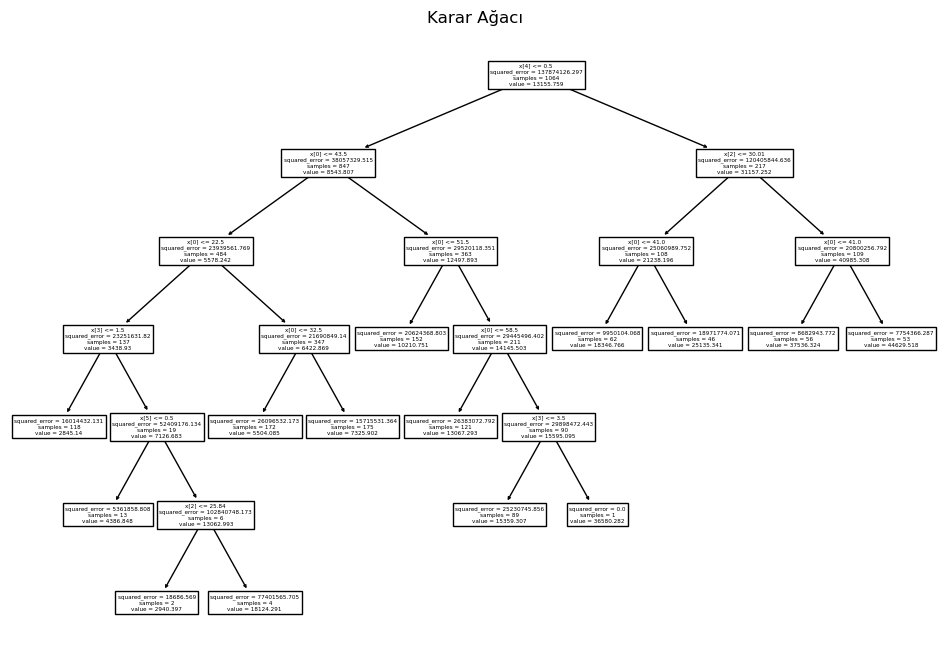

In [141]:
plt.figure(figsize=(12,8))
plot_tree(DT_model_best)
plt.title('Karar Ağacı')
plt.show()

## Bagging (Bootstrap Aggregation)

Bagging, aynı modelin farklı alt veri setleri üzerinde eğitilerek, bu modellerin tahminlerinin birleştirilmesi işlemidir. Bu yöntem, özellikle karar ağaçları gibi yüksek varyansa sahip modellerle etkilidir.


1. Bootstrap örnekleme:

- Eğitim verisinden rastgele alt kümeler oluşturulur.

- Bu alt kümeler, yeniden örnekleme yöntemiyle elde edilir; yani bazı gözlemler birden fazla kez seçilebilir.

2. Modellerin Eğitilmesi:

- Her alt küme üzerinde aynı model (örneğin karar ağacı) eğitilir.

3. Tahminlerin Birleştirilmesi:

- Sınıflandırma için: Her modelin tahmin ettiği sınıfın çoğunluk oyu alınır.

- Regresyon için: Modellerin tahminlerinin ortalaması alınır.

Cross validation score yöntemi egitim verisini belirli bir parçalara bölüp (genelde 5 veya 10) böldüğü parçalardan 1 tanesi test geri kalan eğitim verisi olarak kalır ve buna göre tahmin metriklerinin skorlarını hesaplar ve bunu 5 veya 10 kere tekrarladıkdan sonra bu metriklerin ortalaması alınır. Dolayısıyla daha güvenilir bir metrik hesaplaması ortaya koyar.

In [171]:
bagging_model = BaggingRegressor().fit(x_egitim,y_egitim)
r2 = cross_val_score(bagging_model,x_egitim,y_egitim,cv=5,scoring='r2').mean()
error = -1*cross_val_score(bagging_model,x_egitim,y_egitim,cv=5,scoring='neg_mean_squared_error').mean()

print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

R^2 değeri: 0.8015
mean squared error (MSE) değeri: 26437369.0246


Burada GridSearchCV kullanmak yerine manuel bir şekilde hiperparametre optimizasyonu yaptım.

In [172]:
best_r2 = -float('inf')
error_min = float('inf')
best_param = {}
r2_list = []
n_list = []
error_list = []

estimators = range(1,80)
for n in estimators:
    
    model = BaggingRegressor(estimator=DT_model_best, n_estimators=n, bootstrap=True).fit(x_egitim,y_egitim)
    pred = model.predict(x_test)
    r2_cv = cross_val_score(model,x_egitim,y_egitim,cv=5,scoring='r2').mean()
    error_cv = cross_val_score(model,x_egitim,y_egitim,cv=5,scoring='neg_mean_squared_error').mean()
    
    if r2_cv > best_r2:
        best_r2 = r2_cv
        error_min = error
        n_best = n
        best_param = {
            'n_estimators':n
        }
    r2_list.append(r2_cv)
    n_list.append(n)
    error_list.append(error_cv)
    
print(f'R^2 değeri: {best_r2:.4f}')
print(f'mean squared error (MSE) değeri: {error_min:.4f}')
print(f'en iyi n_estimator değeri: {n}')

R^2 değeri: 0.8462
mean squared error (MSE) değeri: 26437369.0246
en iyi n_estimator değeri: 79


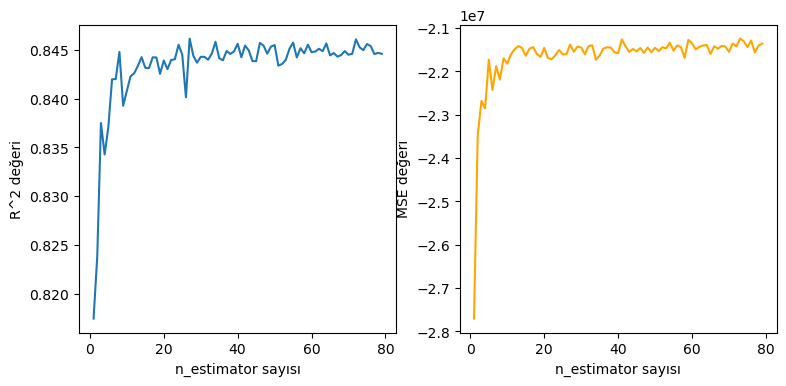

In [173]:
fig,axs = plt.subplots(1,2,figsize=(9,4))
axs[0].plot(n_list,r2_list,label='R^2')
axs[0].set_xlabel('n_estimator sayısı')
axs[0].set_ylabel('R^2 değeri')

axs[1].plot(n_list,error_list,label='MSE',color='orange')
axs[1].set_xlabel('n_estimator sayısı')
axs[1].set_ylabel('MSE değeri')
plt.show()

### Rassal Orman (Random Forest)

Random Forest, bir ensemble (topluluk) yöntemidir ve çok sayıda karar ağacının birleşimiyle çalışan güçlü bir makine öğrenmesi algoritmasıdır.

1. Rastgele özellik seçimi:
- Her ağacın her düğümünde, bölme için tüm özellikler yerine sadece rastgele bir alt küme değerlendirilir.

2. Model eğitimi:
- Her alt küme ile ayrı bir karar ağacı eğitilir.
3. Tahmin:
- Ağaçların tahminlerinin ortalaması alınır.

In [105]:
rf_model = RandomForestRegressor(oob_score=True, bootstrap=True).fit(x_egitim,y_egitim)
pred = rf_model.predict(x_test)

r2 = r2_score(y_test,pred)
error = mean_squared_error(y_test,pred)
print(f'oob skoru: {rf_model.oob_score_:.4f}')
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}');

oob skoru: 0.8324
R^2 değeri: 0.8261
mean squared error (MSE) değeri: 21840961.5652


In [131]:
params = {
    'n_estimators':range(30,80,4),
    'max_depth':range(2,30,2),
    'min_samples_split':range(2,30,3),
    'max_features': [1.0, 'sqrt', 'log2'],
}
RS_model_rf = GridSearchCV(rf_model, params, cv=5,n_jobs=4,verbose=2).fit(x_egitim,y_egitim)
pred = RS_model_rf.predict(x_test)

r2 = r2_score(y_test,pred)
error = mean_squared_error(y_test,pred)
print(f'oob skoru: {RS_model_rf.best_estimator_.oob_score_:.4f}')
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(RS_model_rf.best_params_)


Fitting 5 folds for each of 5460 candidates, totalling 27300 fits
oob skoru: 0.8557
R^2 değeri: 0.8642
mean squared error (MSE) değeri: 17062861.1119
{'max_depth': 4, 'max_features': 1.0, 'min_samples_split': 8, 'n_estimators': 70}


In [136]:
model = RandomForestRegressor(oob_score=True, bootstrap=True,
                              **{'max_depth': 4, 'max_features': 1.0, 'min_samples_split': 8, 'n_estimators': 70})
model.fit(x_egitim,y_egitim)
pred = model.predict(x_test)
r2 = r2_score(y_test,pred)
error = mean_squared_error(y_test,pred)

print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

R^2 değeri: 0.8654
mean squared error (MSE) değeri: 16912181.7446


## Gradient Boosting

Gradient Boosting, tahmin hatalarını azaltmak için modelleri adım adım birbirinin üzerine ekleyen bir topluluk öğrenme (ensemble learning) yöntemidir.
1. İlk tahmin: Ortalama değer
2. Gerçek − Tahmin = Hata
3. Yeni ağaç bu hataları öğrenmeye çalışır
4. Yeni tahmin = önceki tahmin + (hata × öğrenme oranı)
5. Döngü devam eder

In [117]:
GB_model = GradientBoostingRegressor().fit(x_egitim,y_egitim)
pred = GB_model.predict(x_test)

r2 = r2_score(y_test,pred)
error = mean_squared_error(y_test,pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')

R^2 değeri: 0.8651
mean squared error (MSE) değeri: 16944023.9928


In [130]:
params = {
    'learning_rate':[0.01,0.1,0.5],
    'max_depth':range(2,10,1),
    'min_samples_split':range(2,15,2),
    'max_features':[1.0]
}

RS_model_gb = GridSearchCV(GB_model,params,cv=5,n_jobs=4,verbose=2).fit(x_egitim,y_egitim)
pred = RS_model_gb.predict(x_test)
r2 = r2_score(y_test,pred)
error = mean_squared_error(y_test,pred)
print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(RS_model_gb.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
R^2 değeri: 0.8692
mean squared error (MSE) değeri: 16433720.1598
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 1.0, 'min_samples_split': 10}


## XGBoost

Gradient Boosting algoritmasının daha hızlı, daha güçlü ve daha esnek bir versiyonudur.
1. Başlangıçta tüm örnekler için bir tahmin yapılır (genelde ortalama).
2. Hatalar (residuals) hesaplanır.
3. Bu hataları tahmin etmeye çalışan yeni bir ağaç oluşturulur.
4. Yeni tahmin = eski tahmin + (yeni ağaç × learning_rate)
5. Bu işlem istenen ağaç sayısına kadar devam eder.

In [175]:
model= XGBRegressor().fit(x_egitim,y_egitim)
pred= model.predict(x_test)

mean_squared_error(y_test, pred)
r2_score(y_test, pred)

0.8466301815955386

In [282]:
xgb_params = {
    'objective':['reg:squarederror'],
    'eval_metric':['rmse'],
    'max_depth':range(3,10),
    'learning_rate':[0.01,0.05],
    'n_estimators':range(1,100),
}
xgb_model = GridSearchCV(model,xgb_params,cv=5,verbose=2,n_jobs=-1).fit(x_egitim,y_egitim)
pred = xgb_model.predict(x_test)
r2 = r2_score(y_test,pred)
error = mean_squared_error(y_test,pred)

print(f'R^2 değeri: {r2:.4f}')
print(f'mean squared error (MSE) değeri: {error:.4f}')
print(xgb_model.best_params_)

Fitting 5 folds for each of 1386 candidates, totalling 6930 fits
R^2 değeri: 0.9027
mean squared error (MSE) değeri: 12847706.1176
{'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 83, 'objective': 'reg:squarederror'}


## En İyi Model: XGBoost

Bu projede yapılan denemeler sonucunda, **XGBoost** modelinin en iyi performansı gösterdiği belirlenmiştir. XGBoost, gradient boosting algoritmasının iyileştirilmiş bir versiyonudur ve doğrusal olmayan ilişkileri etkili şekilde yakalayarak güçlü tahminler sağlar.

- **Hızlı Eğitim**: Paralel işlem yapabilme özelliği ile daha hızlı eğitim sağlar.
- **Regularizasyon**: Overfitting'i engellemek için L1 ve L2 regularizasyonları kullanılır.
- **Yüksek Performans**: Diğer modellerle karşılaştırıldığında, **R² skoru** ve **hata metriklerinde** en yüksek doğruluğa ulaşılmıştır.


XGBoost, **en iyi model** olarak seçilmiş ve ilerleyen tahminler için kullanılacaktır.
